In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve 

In [3]:
df = pd.read_csv('Bank_Churn_Dataset.csv')
print(df.shape)
df.sample(10)

(10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
6237,15778897,630,France,Female,28,1,0.00,2,1,1,133267.78,0
8777,15723064,603,Spain,Male,24,1,165149.13,2,1,0,21858.28,0
4161,15611371,736,France,Male,43,4,176134.54,1,1,1,52856.88,0
3235,15612465,684,Spain,Male,34,9,100628.00,2,1,1,190263.78,0
6028,15673439,646,Spain,Female,50,5,142644.64,2,1,1,142208.50,1
9708,15604515,737,Germany,Female,22,10,111543.26,2,0,0,106327.85,0
2001,15734311,661,France,Female,27,3,0.00,2,1,1,76889.79,0
5558,15645355,677,Germany,Male,34,3,126729.41,1,1,1,26106.39,1
7537,15773776,655,France,Female,38,6,0.00,1,1,1,188639.28,0
1337,15650889,710,Germany,Female,30,10,133537.10,2,1,0,155593.74,0


## Data Preprocessing

In [4]:
df.drop('customer_id' , axis=1 , inplace=True)

In [5]:
#Apply one-hot encoding to Categorical Features
df2 = pd.get_dummies(data=df, columns=['country','gender'] , dtype=int)

In [6]:
#Feature Scaling
col_to_scale = ['credit_score','tenure','balance','products_number','age','estimated_salary']
scaler = MinMaxScaler()
df2[col_to_scale] = scaler.fit_transform(df2[col_to_scale])
df2.sample(10)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
7855,0.632,0.554054,0.8,0.608273,0.333333,1,1,0.943944,0,0,1,0,1,0
7273,0.620,0.270270,0.6,0.437904,0.000000,1,1,0.773225,0,0,0,1,0,1
2225,0.702,0.270270,0.3,0.499747,0.333333,0,1,0.260190,0,0,1,0,0,1
6809,0.668,0.108108,0.5,0.347149,0.000000,0,0,0.530472,0,1,0,0,1,0
7013,0.796,0.216216,0.8,0.000000,0.333333,1,0,0.267888,0,1,0,0,1,0
9807,0.598,0.243243,0.8,0.000000,0.333333,0,1,0.545894,0,1,0,0,1,0
4123,0.604,0.270270,0.1,0.414094,0.000000,0,1,0.798266,0,0,0,1,1,0
5564,0.518,0.283784,0.2,0.555778,0.333333,1,0,0.046117,0,0,0,1,0,1
6480,0.658,0.081081,0.6,0.458149,0.333333,0,1,0.678848,0,1,0,0,1,0
3910,0.540,0.702703,0.3,0.350446,0.333333,1,0,0.166709,1,1,0,0,1,0


In [7]:
#Features and Target variable
x = df2.drop('churn',axis=1)
y = df2['churn']

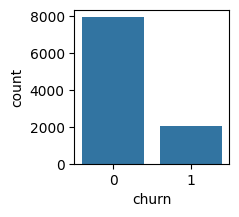

In [8]:
#Distribution of the target variable
plt.figure(figsize=(2,2))
sns.countplot(x='churn' , data = df)
plt.show()

In [9]:
#Split the Dataset for Training and Testing 
x_train , x_test , y_train , y_test = train_test_split(x , y, train_size = 0.8 , random_state = 42)

print(f"x shape: {x.shape}, y shape: {y.shape}")
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x shape: (10000, 13), y shape: (10000,)
X_train shape: (8000, 13), y_train shape: (8000,)
X_test shape: (2000, 13), y_test shape: (2000,)


In [10]:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64
churn
0    0.7945
1    0.2055
Name: proportion, dtype: float64
churn
0    0.8035
1    0.1965
Name: proportion, dtype: float64


In [11]:
#Apply oversampling to the minority class using Synthetic Minority Over-sampling Technique (SMOTE)
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(x_train, y_train)
y_sm.value_counts(normalize=True)

churn
0    0.5
1    0.5
Name: proportion, dtype: float64

## Model Training

In [12]:
model = {
    'Logestic' : LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'Random_Forest' : RandomForestClassifier(),
    'XGB' : XGBClassifier()
}

param = {
    'Logestic' : {
        'C': [0.1, 1, 10], 
        'max_iter': [10000] 
    },
    'KNN' : {
        'n_neighbors': [3, 5, 7, 10, 15, 20],  
        'weights': ['uniform', 'distance'] 
    },
    'Random_Forest' : {
         'n_estimators': [100, 200],
         'max_depth' : [None, 10 ,20],
         'min_samples_leaf': [1,2],
         'min_samples_split': [2,5,10]
    },
    'XGB' : {
        'n_estimators': [100, 200],
        'max_depth': [3, 5 , 7],
        'learning_rate' : [0.01 , 0.1, 0.5],
        'gamma' : [0.01, 0.1, 0.5]
    }
}

In [13]:
def calc_metric(y_true , y_pred , y_prob):
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1score = f1_score(y_true , y_pred)
    roc_auc = roc_auc_score(y_true , y_prob)
    return (accuracy , precision , recall , f1score , roc_auc)

In [14]:
def find_best_model(model, param, x_train, y_train, x_test, y_test):
    model_performance = []
    fitted_model = {}

    for model_name, model in model.items():
        param_grid = param[model_name]
        gs = GridSearchCV(model, param_grid , cv = 5 , n_jobs = -1, scoring='f1')
        gs.fit(x_train, y_train)
        y_pred = gs.predict(x_test)
        y_prob = gs.predict_proba(x_test)[:, 1] 
        accuracy, precision, recall, f1score, roc_auc = calc_metric(y_test, y_pred, y_prob)
        model_performance.append({
            'model' : model_name,
            'best_params' : gs.best_params_,
            'best_score': gs.best_score_,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1score,
            'roc_auc': roc_auc
        })
        fitted_model[model_name] = gs.best_estimator_
    col_name =['model', 'best_params', 'best_score', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']    
    return pd.DataFrame(model_performance, columns=col_name), fitted_model

In [15]:
df_model, fitted_model = find_best_model(model, param, x_sm, y_sm, x_test, y_test)
df_model

,model,best_params,best_score,accuracy,precision,recall,f1_score,roc_auc
0,Logestic,"{'C': 10, 'max_iter': 10000}",0.708264,0.7275,0.392958,0.709924,0.505893,0.783082
1,KNN,"{'n_neighbors': 3, 'weights': 'distance'}",0.876807,0.7420,0.393782,0.580153,0.469136,0.732600
2,Random_Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.900900,0.8395,0.586538,0.620865,0.603214,0.847769
3,XGB,"{'gamma': 0.01, 'learning_rate': 0.1, 'max_dep...",0.874640,0.8455,0.617978,0.559796,0.587450,0.856195


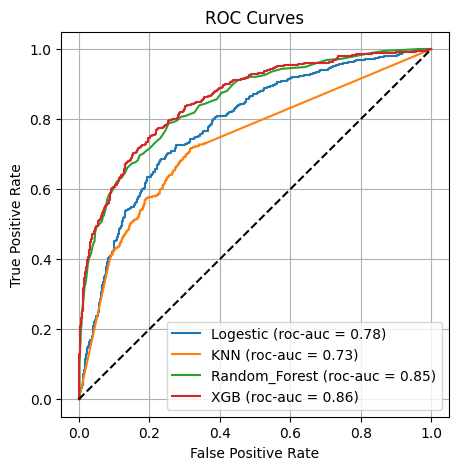

In [23]:
def plot_roc_curves(y_test, fitted_models):
    plt.figure(figsize=(5, 5))

    for model_name, model in fitted_models.items():
        y_prob_test = model.predict_proba(x_test)[:, 1]  
        fpr, tpr, _ = roc_curve(y_test, y_prob_test) 
        roc_auc = roc_auc_score(y_test, y_prob_test)  

        plt.plot(fpr, tpr, label='{} (roc-auc = {:.2f})'.format(model_name, roc_auc))

    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curves(y_test, fitted_model)


In [17]:
best_model_v1 = fitted_model['Random_Forest']  
best_model_v2 = fitted_model['XGB'] 

#### Random Forest Model

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1607
           1       0.59      0.62      0.60       393

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.84      0.84      2000



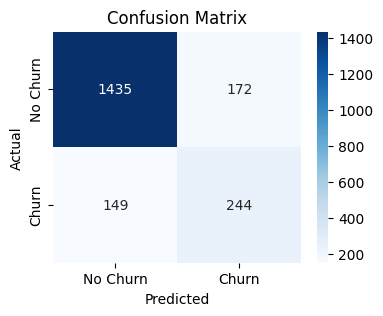

In [24]:
y_pred_test = best_model_v1.predict(x_test)
y_prob_test = best_model_v1.predict_proba(x_test)[:,1]

class_rep = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_rep)

conf_mat = confusion_matrix(y_test , y_pred_test)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### XGB Model

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1607
           1       0.62      0.56      0.59       393

    accuracy                           0.85      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000



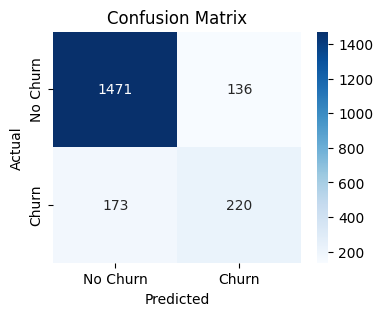

In [19]:
y_pred_test = best_model_v2.predict(x_test)
y_prob_test = best_model_v2.predict_proba(x_test)[:,1]

class_rep = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_rep)

conf_mat = confusion_matrix(y_test , y_pred_test)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Saving the best models and artifacts for deployment


In [20]:
#Save Columns Names as JSON
data_columns = [col for col in x.columns]

import json
columns = {'data_columns' : data_columns}
with open ('data_columns.json' , 'w') as f:
    json.dump(columns , f)

In [21]:
#Save ML Models
import pickle
with open('model_v1.pickle' , 'wb') as f:
    pickle.dump(best_model_v1 , f)
with open('model_v2.pickle' , 'wb') as f:
    pickle.dump(best_model_v2 , f) 